In [1]:
import pandas as pd
import numpy as np
from preprocess import *
from util import *
from model import *
import matplotlib.pyplot as plt
import pickle
from scipy.stats import sem
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau
from interpretation import missingness_plot
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import Model, regularizers
import shap
import matplotlib as mpl
shap.initjs()

%matplotlib inline

2022-11-05 17:43:24.668319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 17:43:24.668346: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
c = Connection(verbose=True)

c.clean_clinic_data(miss_rate=0.2, cleaned_version=False, max_gcs=15, ext_subjects=True)
c.clean_vital_data()
c.clean_lab_data()
c.clean_gcs_data()
# c.vital_freq()
# df = c.time_series(only_icu=False)

Columns (44,83) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (0,1,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Column PresSeizuresDuration has been dropped
Column EDAbgFiO2 has been dropped
Column EDAbgBd has been dropped
Column EDAbgBe has been dropped
Column EDAbgBicarbonate has been dropped
Column EDAbgPaO2 has been dropped
Column EDAbgPaCO2 has been dropped
Column EDOsmo has been dropped
Column EDProthrombineTime has been dropped
Column EDLactate has been dropped
Column EDaPtt has been dropped
Column EDAbgPH has been dropped
Column EDDischTemp has been dropped
Column EDArrTemp has been dropped
Column EDDrugScreenAlcohol has been dropped
Column EDDrugScreenAlcoholLess10mgdl has been dropped
Column ConsentWithdrawnTimeSinceInj has been dropped
Column DeathTimeSinceInj has been dropped
Column Rem_Day has been dropped
Column Rem_Time has been dropped
Column DeathCause has been dropped
Column DeathCauseOther has been dropped
Column BrainDonor has been dropped
Column ApptResultMRI6Mo has been dropped
Column GcsEdArrManualScore has been dropped
Column MonitorCPP has been dropped
Column MonitorPuls

In [3]:
output_type = 'Binary'
missing_rate = 0.5

values, pat_ind, var_ind = ts_builder_3d(c, max_len=24, masking=False)

# Populating the output
guid = list(pat_ind.keys())
vars = list(var_ind.keys())
dem_df = c.clinic_data[c.clinic_data.Guid.isin(guid)]
outcomes = np.zeros(len(guid))
for row in dem_df.itertuples():
    pind = pat_ind[getattr(row, 'Guid')]
    outcomes[pind] = getattr(row, 'GOSEScore')

# Calculating aggregated values
values_mean = np.nanmean(values, axis=1)
values_max = np.nanmax(values, axis=1)
values_min = np.nanmin(values, axis=1)

# Dropping columns with high missingness
dropped_ind = np.where(np.isnan(values_mean).sum(axis=0)/902 > missing_rate)[0]
values_mean = np.delete(values_mean, dropped_ind, axis=1)
values_max = np.delete(values_max, dropped_ind, axis=1)
values_min = np.delete(values_min, dropped_ind, axis=1)
vars = np.delete(vars, dropped_ind)

# Concatinating columns
# input_values = np.concatenate((values_mean, values_max), axis=1)
input_values = values_mean
input_vars = vars
# input_vars = ['AVG_' + i for i in vars]
# input_vars = np.concatenate((input_vars, ['MAX_' + i for i in vars]))
# input_vars = np.concatenate((input_vars, ['MIN_' + i for i in vars]))
input_vars = [ALL_VAR_MAP[x] if x in ALL_VAR_MAP.keys() else x for x in input_vars]
input_vars = [x[6:] if x.startswith('Daily') else x for x in input_vars]

# Splitting data to test and train
train_dem, test_dem, train_y, test_y = train_test_split(input_values, outcomes,
                                                        test_size=0.2, random_state=0,
                                                        stratify=outcomes)
# Imputing missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_dem = imputer.fit_transform(train_dem)
test_dem = imputer.fit_transform(test_dem)

# Normalizing
train_scaler, test_scaler = StandardScaler(), StandardScaler()
train_dem = train_scaler.fit_transform(train_dem)
test_dem = test_scaler.fit_transform(test_dem)

# Discretizing the outcome
train_y, num_output = output_builder(train_y, output_type)
test_y, _ = output_builder(test_y, output_type)

# FLIPPING THE OUTPUTS ----->> 0: Favorable, 1: Unfavorable
train_y = 1 - train_y
test_y = 1 - test_y

352721it [00:00, 707854.34it/s]
Mean of empty slice
All-NaN slice encountered
All-NaN slice encountered


In [4]:
ALL_VAR_MAP = {'EDPlatelet': 'ED measured Platelet',
 'EDWbc': 'ED measured WBC',
 'EDComplEventHypoxia': 'Complication Hypoxia',
 'EDComplEventHypotension': 'Complication Hypotension',
 'EDComplEventSeizures': 'Complication Seizures',
 'EDComplEventCardArr': 'Complication CardArr',
 'EDInr': 'ED measured INR',
 'PresIntubation':'ED intubated',
 'EDBun': 'ED measured BUN',
 'EDCreatinine': 'ED measured Creatinine',
 'EDGlucose': 'ED measured Glucose',
 'EDCO2': 'ED measured CO2',
 'EDChloride': 'ED measured Chloride',
 'EDPotassium': 'ED measured Potassium',
 'EDSodium': 'ED measured Sodium',
 'EDDischSpO2': 'ED Discharge measured SPO2',
 'EDArrSBP': 'ED Arrival measured SBP',
 'EDArrHR': 'ED Arrival measured HR',
 'EDArrSpO2': 'ED Arrival measured SPO2',
 'EDDischSBP': 'ED Arrival measured SBP',
 'EDDischDBP': 'ED Arrival measured DBP',
 'EDDischHR': 'ED Discharge measured HR',
 'EDArrDBP': 'ED Arrival DBP',
 'EDDrugScreenCocaine': 'ED Drug Screen: Cocaine',
 'EDDrugScreenAmph': 'ED Drug Screen: AMPH',
 'EDDrugScreenPCP': 'ED Drug Screen: PCP',
 'EDDrugScreenCannabis': 'ED Drug Screen: Cannabis',
 'EDDrugScreenMethadone': 'ED Drug Screen: Methadone',
 'EDHemoglobin': 'ED measured Hemoglobin',
 'EDDrugScreenBenzo': 'ED Drug Screen: Benzo',
 'EDDrugScreenBarb': 'ED Drug Screen: Barb',
 'EDDrugScreenOpioids': 'ED Drug Screen: Opioids',
 'AgeRecodedPHI': 'Age',
 'PatientType': 'ICU addmission status',
 'Sex': 'Sex=Female',
 'GCS': 'ED measured total GCS',
 'mGCS': 'ED numeric measured GCS Motor',
 'GcsEDArrMotor_1-No Response': 'ED measured GCS Motor=No Response',
 'GcsEDArrMotor_2-Extension': 'ED measured GCS Motor=Extension',
 'GcsEDArrMotor_3-Flexion Abnormal': 'ED measured GCS Motor=Flexion Abnormal',
 'GcsEDArrMotor_4-Flexion Withdrawal': 'ED measured GCS Motor=Flexion Withdrawal',
 'GcsEDArrMotor_5-Localizes to Pain': 'ED measured GCS Motor=Localize to Pain',
 'GcsEDArrMotor_6-Obeys Commands': 'ED measured GCS Motor=Obeys Command',
 'GcsEDArrMotor_P-Untestable (Paralyzed)': 'ED measured GCS Motor=Untestable (Paralyzed)',
 'EDComplEventAsp_No': 'Complication ASP=No',
 'EDComplEventAsp_Suspected': 'Complication ASP=Suspected',
 'EDComplEventAsp_Yes': 'Complication ASP=Yes',
 'Pupils_Both': 'ED Pupils Reactivity=Both',
 'Pupils_Missing at least one eye': 'ED Pupils Reactivity=Missing at least one eye',
 'Pupils_Neither': 'ED Pupils Reactivity=Neither',
 'Pupils_One': 'ED Pupils Reactivity=One',
 'DLAlatSgpt': 'Daily Lab AlatSgpt',
 'DLAlkalinePhosphatase': 'Daily Lab AlkalinePhosphatase',
 'DLAmylase': 'Daily Lab Amylase',
 'DLAsatSgot': 'Daily Lab AsatSgot',
 'DLBd': 'Daily Lab Bd',
 'DLBe': 'Daily Lab Be',
 'DLBicarbonate': 'Daily Lab Bicarbonate',
 'DLCalcium': 'Daily Lab Calcium',
 'DLCreatinine': 'Daily Lab Creatinine',
 'DLEosinophils': 'Daily Lab Eosinophils',
 'DLFibrinogen': 'Daily Lab Fibrinogen',
 'DLGlucose': 'Daily Lab Glucose',
 'DLHematocrit': 'Daily Lab Hematocrit',
 'DLHemoglobin': 'Daily Lab Hemoglobin',
 'DLInr': 'Daily Lab Inr',
 'DLLactate': 'Daily Lab Lactate',
 'DLLdh': 'Daily Lab Ldh',
 'DLLymphocytes': 'Daily Lab Lymphocytes',
 'DLMagnesium': 'Daily Lab Magnesium',
 'DLNeutrophils': 'Daily Lab Neutrophils',
 'DLOtherWbc': 'Daily Lab OtherWbc',
 'DLPaCO2': 'Daily Lab PaCO2',
 'DLPaO2': 'Daily Lab PaO2',
 'DLPh': 'Daily Lab Ph',
 'DLPlatelet': 'Daily Lab Platelet',
 'DLPotassium': 'Daily Lab Potassium',
 'DLProthrombineTime': 'Daily Lab Prothrombine Time',
 'DLSodium': 'Daily Lab Sodium',
 'DLTotalBilirubin': 'Daily Lab Total Bilirubin',
 'DLUrea': 'Daily Lab Urea',
 'DLWbc': 'Daily Lab Wbc',
 'DLaPtt': 'Daily Lab aPtt',
 'DVDBP': 'Daily Vitals DBP',
 'DVHR': 'Daily Vitals HR',
 'DVResTyp_Intubation': 'Daily Respiratory=Intubated',
 'DVResTyp_NIPPV': 'Daily Respiratory=NIPPV',
 'DVResTyp_Non-Intubated': 'Daily Respiratory=NonItubated',
 'DVSBP': 'Daily Vitals SBP',
 'DVSpO2': 'Daily Vitals SPO2',
 'DvTemp': 'Daily Vitals Temperature',
 'GCSEye_1-No Response': 'Daily GCS Eye=No Response',
 'GCSEye_2-To Pain': 'Daily GCS Eye=To Pain',
 'GCSEye_3-To Verbal Command': 'Daily GCS Eye=To Verbal Command',
 'GCSEye_4-Spontaneously': 'Daily GCS Eye=Spontaneously',
 'GCSEye_S-Untestable (Swollen)': 'Daily GCS Eye=Untestable',
 'GCSMtr_1-No Response': 'Daily GCS Motor=No Response',
 'GCSMtr_2-Extension': 'Daily GCS Motor=Extension',
 'GCSMtr_3-Flexion Abnormal': 'Daily GCS Motor=Flexion Abnormal',
 'GCSMtr_4-Flexion Withdrawal': 'Daily GCS Motor=Flexion Withdrawal',
 'GCSMtr_5-Localizes to Pain': 'Daily GCS Motor=Localize to Pain',
 'GCSMtr_6-Obeys Commands': 'Daily GCS Motor=Obeys Commands',
 'GCSMtr_P-Untestable (Paralyzed)': 'Daily GCS Motor=Untestable',
 'GCSVrb_1-No Response': 'Daily GCS Verbal=No Response',
 'GCSVrb_2-Incomprehensible Sounds': 'Daily GCS Verbal=Incomprehensible Sounds',
 'GCSVrb_3-Inappropriate Words': 'Daily GCS Verbal=Inappropriate Words',
 'GCSVrb_4-Disoriented & Converses': 'Daily GCS Verbal=Disoriented & Converses',
 'GCSVrb_5-Oriented & Converses': 'Daily GCS Verbal=Oriented & Converses',
 'GCSVrb_T-Untestable (Artificial Airway)': 'Daily GCS Verbal=Untestable',
 'PupilReactivity_Both': 'Daily Pupil Reactivity=Both',
 'PupilReactivity_Neither': 'Daily Pupil Reactivity=Neither',
 'PupilReactivity_One': 'Daily Pupil Reactivity=One',
 'PupilReactivity_Untestable': 'Daily Pupil Reactivity=Untestable'}
input_vars = vars
# input_vars = ['AVG_' + i for i in vars]
# input_vars = np.concatenate((input_vars, ['MAX_' + i for i in vars]))
# input_vars = np.concatenate((input_vars, ['MIN_' + i for i in vars]))
input_vars = [ALL_VAR_MAP[x] if x in ALL_VAR_MAP.keys() else x for x in input_vars]
input_vars = [x[6:] if x.startswith('Daily') else x for x in input_vars]
var_ind = inv_list(input_vars)

# Deep Learning Model

In [10]:
es_patience = 70
learning_rate = 0.0002
epochs = 3000
activation_dict = {'Regression': None,
                   'Binary': 'sigmoid',
                   'Multiclass': 'softmax',
                   'OrdinalMulticlass': 'sigmoid'}
loss_dict = {'Regression': 'mean_squared_error',
             'Binary': 'binary_crossentropy',
             'Multiclass': 'categorical_crossentropy',
             'OrdinalMulticlass': 'mean_squared_error'}

inp_x = Input(shape=(train_dem.shape[1]))
x = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.2))(inp_x)
x = Dropout(0.3)(x)
x = Dense(40, activation='tanh', kernel_regularizer=regularizers.l2(0.2))(x)
x = Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.2))(x)
out_x = Dense(num_output, activation=activation_dict[output_type])(x)

# Creating and compiling model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience, restore_best_weights=True)

model = Model(inputs=inp_x, outputs=out_x)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_dict[output_type],
              metrics=['accuracy'])
model.summary()
train_history = model.fit(train_dem, train_y, batch_size=8,
                          epochs=epochs, verbose=2,
                          validation_split=0.2,
                          callbacks=[es])

2022-02-28 20:44:31.667303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-28 20:44:31.667338: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-28 20:44:31.667369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0ff02e6dbb19): /proc/driver/nvidia/version does not exist
2022-02-28 20:44:31.667565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-28 20:44:31.723337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR O

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               4900      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 9,571
Trainable params: 9,571
Non-trainable params: 0
___________________________________________________________

In [11]:
evaluation(test_y, model.predict(test_dem), metric='AUC', output_type='Binary')

0.8037234042553192

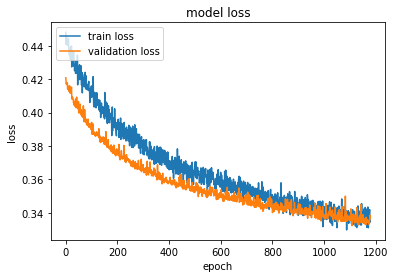

In [12]:
drop_items = 100
plt.plot(train_history.history['loss'][drop_items:])
plt.plot(train_history.history['val_loss'][drop_items:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.show()

# SVM Model

In [5]:
from sklearn.svm import SVC
svm_model = SVC(probability=True)
svm_model.fit(train_dem, train_y)

SVC(probability=True)

In [6]:
from sklearn.metrics import recall_score, roc_auc_score, precision_score
print(roc_auc_score(test_y, svm_model.predict(test_dem)))
print(recall_score(test_y, svm_model.predict(test_dem), pos_label=1))
print(precision_score(test_y, svm_model.predict(test_dem), pos_label=1))

0.7535714285714287
0.55
0.7857142857142857


In [7]:
test_y - svm_model.predict_proba(test_dem)[:,1].T

array([-0.06400668, -0.02712662,  0.06966577, -0.01990109, -0.59443298,
       -0.15204864, -0.77400614, -0.07431762, -0.46319061, -0.20982351,
       -0.01878372, -0.03776789, -0.05114174, -0.02678057, -0.04743882,
        0.4301081 ,  0.10461408,  0.17191169, -0.03158154, -0.03007722,
       -0.05008347, -0.06154675, -0.37716304, -0.26732891, -0.02662827,
       -0.34301298, -0.06080183, -0.0299698 ,  0.5       , -0.04402327,
       -0.05323345, -0.01891502, -0.06199219, -0.03902163,  0.66914911,
       -0.07479862, -0.145804  , -0.04562558, -0.33081155, -0.02606713,
       -0.21592623,  0.43333113, -0.62895013, -0.04298572, -0.1415877 ,
        0.09420784, -0.05588171, -0.04204601, -0.10384311,  0.78782869,
       -0.10924542,  0.05848431,  0.89412724, -0.07925438, -0.06658748,
       -0.05062656, -0.1096321 ,  0.52432248, -0.05535953, -0.05369547,
       -0.03009161,  0.87227795,  0.04973241,  0.06558756, -0.02637691,
        0.24495596,  0.25209243, -0.06201922, -0.05717661, -0.69

# SHAP

In [8]:
explainer = shap.KernelExplainer(svm_model.predict_proba, train_dem[:30])
shap_values = explainer.shap_values(test_dem[:180])

  0%|          | 0/180 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [41]:
index = 4
shap.force_plot(explainer.expected_value[1], shap_values[1][index], input_vars)

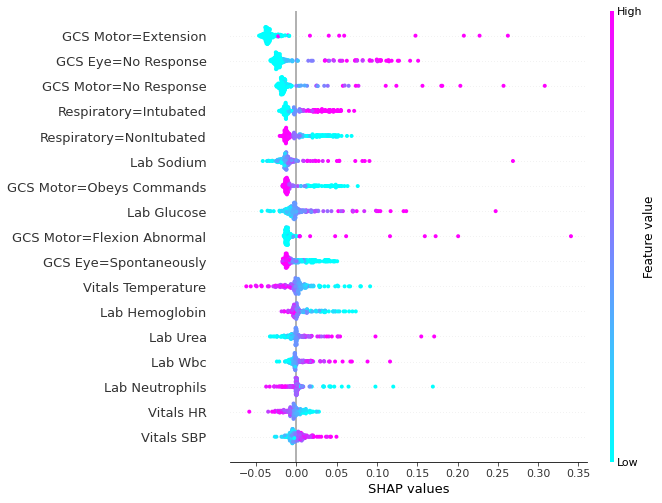

In [10]:
shap.plots._labels.labels['VALUE'] = 'SHAP values'
shap.summary_plot(shap_values[1], features=test_dem[:180], feature_names=input_vars, max_display=17,
                  cmap=mpl.cm.cool, title='sdfdf')

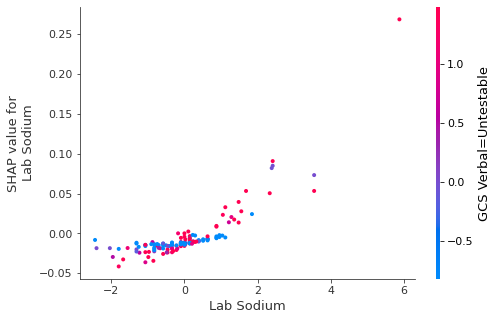

In [11]:
shap.dependence_plot('Lab Sodium', shap_values[1], features=test_dem[:180], feature_names=input_vars)

# LIME

In [42]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer = LimeTabularExplainer(train_dem, feature_names=input_vars, class_names=['Favorable', 'Unfavorable'], discretize_continuous=False)
lime_exp = lime_explainer.explain_instance(test_dem[index], svm_model.predict_proba, num_features=47, top_labels=2)

In [ ]:
lime_exp.show_in_notebook(show_table=False)

In [43]:
lime_vals = np.array([i[1] for i in lime_exp.local_exp[1]])
lime_vars = [input_vars[i[0]] for i in lime_exp.local_exp[1]]
shap.force_plot(lime_exp.intercept[1], lime_vals, lime_vars)

In [44]:
lime_vals = np.array([i[1] * float(lime_exp.domain_mapper.feature_values[i[0]]) for i in lime_exp.local_exp[1]])
shap.force_plot(lime_exp.intercept[1], lime_vals, lime_vars)

In [16]:
num_samples = 180
num_features = len(var_ind)
lime_vals_glob = np.zeros((num_samples, num_features))
for i in range(num_samples):
    lime_explainer = LimeTabularExplainer(train_dem, feature_names=input_vars, class_names=['Unfavorable', 'Favorable'], discretize_continuous=False)
    lime_exp = lime_explainer.explain_instance(test_dem[i], svm_model.predict_proba, num_features=num_features, top_labels=2)
    lime_vals = np.array([i[1] * float(lime_exp.domain_mapper.feature_values[i[0]]) for i in lime_exp.local_exp[1]])
    lime_vars = [input_vars[i[0]] for i in lime_exp.local_exp[1]]
    for j in range(num_features):
        f_ind = var_ind[lime_vars[j]]
        lime_vals_glob[i,f_ind] = lime_vals[j]

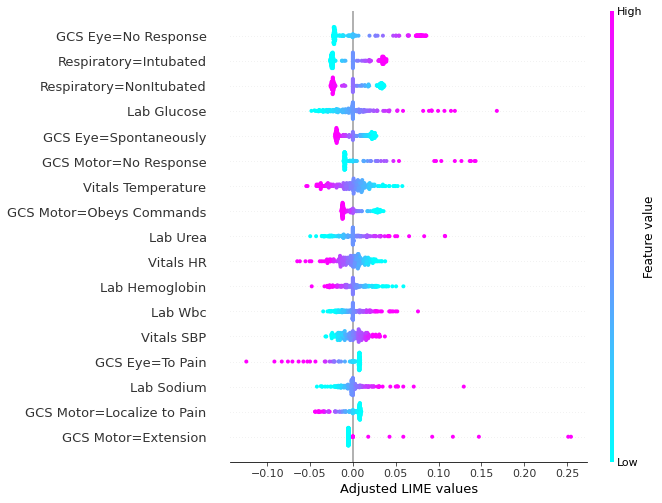

In [17]:
shap.plots._labels.labels['VALUE'] = 'Adjusted LIME values'
shap.summary_plot(lime_vals_glob, features=test_dem[:180], feature_names=input_vars, max_display=17, cmap=mpl.cm.cool)

# Partial Dependence Plot

In [34]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, plot_partial_dependence
from sklearn.metrics import RocCurveDisplay
from copy import deepcopy
from types import MethodType

In [28]:
svm_model_pdp = deepcopy(svm_model)
# svm_model_pdp.predict_proba = MethodType(lambda x: svm_model.predict_proba(train_scaler.transform(x)), svm_model_pdp)
# svm_model_pdp.predict = MethodType(lambda x: svm_model.predict(train_scaler.transform(x)), svm_model_pdp)
# svm_model_pdp.predict_log_proba = MethodType(lambda x: svm_model.predict_log_proba(train_scaler.transform(x)), svm_model_pdp)
# svm_model_pdp.decision_function = MethodType(lambda x: svm_model.decision_function(train_scaler.transform(x)), svm_model_pdp)

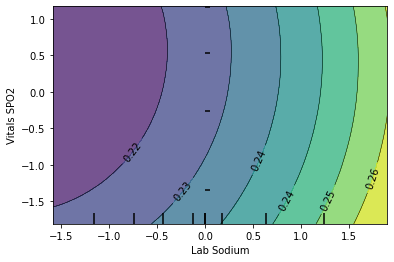

In [38]:
disp1 = PartialDependenceDisplay.from_estimator(svm_model, train_dem, [(13, 23)], feature_names=input_vars, kind='average',
                                                ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                                                pd_line_kw={"color": "tab:orange", "linestyle": "--"})

In [47]:
var_ind["Vitals HR"]

18

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


Text(0, 0.5, 'Probability of unfavorable outcome')

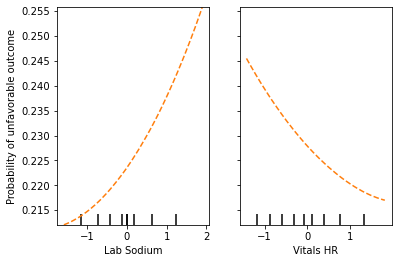

In [48]:

disp2 = plot_partial_dependence(svm_model, train_dem, [13, 18], feature_names=input_vars, kind='average',
                                                ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                                                pd_line_kw={"color": "tab:orange", "linestyle": "--"})
disp2.axes_[0][0].set_ylabel("Probability of unfavorable outcome")



In [35]:
var_ind

{'Lab Calcium': 0,
 'Lab Creatinine': 1,
 'Lab Eosinophils': 2,
 'Lab Glucose': 3,
 'Lab Hematocrit': 4,
 'Lab Hemoglobin': 5,
 'Lab Inr': 6,
 'Lab Lymphocytes': 7,
 'Lab Magnesium': 8,
 'Lab Neutrophils': 9,
 'Lab Platelet': 10,
 'Lab Potassium': 11,
 'Lab Prothrombine Time': 12,
 'Lab Sodium': 13,
 'Lab Urea': 14,
 'Lab Wbc': 15,
 'Lab aPtt': 16,
 'Vitals DBP': 17,
 'Vitals HR': 18,
 'Respiratory=Intubated': 19,
 'Respiratory=NIPPV': 20,
 'Respiratory=NonItubated': 21,
 'Vitals SBP': 22,
 'Vitals SPO2': 23,
 'Vitals Temperature': 24,
 'GCS Eye=No Response': 25,
 'GCS Eye=To Pain': 26,
 'GCS Eye=To Verbal Command': 27,
 'GCS Eye=Spontaneously': 28,
 'GCS Eye=Untestable': 29,
 'GCS Motor=No Response': 30,
 'GCS Motor=Extension': 31,
 'GCS Motor=Flexion Abnormal': 32,
 'GCS Motor=Flexion Withdrawal': 33,
 'GCS Motor=Localize to Pain': 34,
 'GCS Motor=Obeys Commands': 35,
 'GCS Motor=Untestable': 36,
 'GCS Verbal=No Response': 37,
 'GCS Verbal=Incomprehensible Sounds': 38,
 'GCS Verbal=I

In [ ]:
input_vars

# Anchors

In [8]:
from anchor import anchor_tabular

In [19]:
index=4
anchor_exp = anchor_tabular.AnchorTabularExplainer(train_data=train_scaler.inverse_transform(train_dem), feature_names=input_vars, class_names=['Unfavorable', 'Favorable'])
predict_fn = lambda x: svm_model.predict(test_scaler.transform(x))
anchor_val = anchor_exp.explain_instance(test_scaler.inverse_transform(test_dem[index][np.newaxis, :]), predict_fn, threshold=0.95, beam_size=5, delta=0.1, tau=0.1)

In [86]:
import re
rules = anchor_val.names()
print(rules)
print('\n')
for i, rul in enumerate(rules):
    s = re.split('(>|<|>=|<=| = )', rul)
    print('Step {}: ({}) {} {}'.format(i+1, s[0][:-1], s[1], s[2]))
    prec = round(anchor_val.exp_map['precision'][i] * 100)
    cov = round(anchor_val.exp_map['coverage'][i] * 100, 3)
    print('        Precision = {} percent and Coverage = {} percent'.format(prec, cov))
    print('---------------------- \n')

['GCS Motor=No Response <= 0.00', 'Lab Hemoglobin > 13.60', 'Vitals DBP <= 64.21']


Step 1: (GCS Motor=No Response) < = 0.00
        Precision = 81 percent and Coverage = 76.44 percent
---------------------- 

Step 2: (Lab Hemoglobin) >  13.60
        Precision = 92 percent and Coverage = 19.89 percent
---------------------- 

Step 3: (Vitals DBP) < = 64.21
        Precision = 100 percent and Coverage = 3.64 percent
---------------------- 



In [24]:
anchor_val.exp_map['precision']

[0.34556130457531536, 0.7077065494098588, 0.9018126888217523, 1.0]

In [25]:
anchor_val.exp_map['coverage']

[0.0641, 0.0159, 0.0035, 0.002]

# Counter Factual

In [40]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from alibi.explainers import Counterfactual

In [41]:
tf.keras.backend.clear_session()
cf = Counterfactual(svm_model.predict_proba, (1,) + train_dem.shape[1:], tol=0.3)

In [42]:
cf_exp = cf.explain(test_dem[index][np.newaxis, :])

In [44]:
org_cf_x = test_scaler.inverse_transform(cf_exp.cf['X'])
org_x = test_scaler.inverse_transform(test_dem[index][np.newaxis, :])
delta = cf_exp.cf['X'] - test_dem[index][np.newaxis, :]
eps = 0.5
print('Original predcited label is: {}'.format('Unfavorable' if svm_model.predict(test_scaler.transform(org_x)) == 1 else 'Favorable'))
print('-------------- \n')
for i, f in enumerate(input_vars):
    if np.abs(delta[0, i])> eps:
        # print('Delta: {}'.format(delta[0,i]))
        r1 = round(org_x[0,i], 2)
        r2 = round(float(org_cf_x[0,i]), 2)
        print('{} changed from {} to {}'.format(f, r1, r2))
        org_x[0,i] = org_cf_x[0,i]
        print('-------------- \n')
print('New predicted label is: {}'.format('Unfavorable' if svm_model.predict(test_scaler.transform(org_x)) == 1 else 'Favorable'))
print('-------------- \n')


Original predcited label is: Unfavorable
-------------- 

Lab Glucose changed from 126.33 to 102.58
-------------- 

Lab Wbc changed from 22.4 to 18.76
-------------- 

GCS Eye=No Response changed from 1.0 to 0.74
-------------- 

New predicted label is: Favorable
-------------- 



In [30]:
svm_model.predict_proba(cf_exp.cf['X'])

array([[0.72469302, 0.27530698]])